In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from joblib import parallel_backend
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
abc_data = pd.read_csv('../2_Labelled_Data/textblob_label.csv')
abc_data.head()

publish_date                                      headline_text  \
0   2019-01-24  [('malaysia', 'appoint', 'new'), ('appoint', '...   
1   2019-01-21  [('kurti', 'patterson', 'rush'), ('patterson',...   
2   2019-01-31  [('katherin', 'darwin', 'lash'), ('darwin', 'l...   
3   2019-01-26  [('spirit', 'matthew', 'flinder'), ('matthew',...   
4   2019-01-31  [('nsw', 'govern', 'negoti'), ('govern', 'nego...   

  textblob_label  
0       positive  
1        neutral  
2        neutral  
3        neutral  
4       positive

### Feature Extraction and Data Splitting into Train, Test and Validation

In [8]:
# Remove target variable from dataset
target = ['textblob_label']
features = ['headline_text']

X = abc_data[features[0]].values # Get predictor variable (headline_text column)
y = abc_data[target[0]].values # Get target variable (sentiment column)

# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Perform TF normalization on the text data
tf = TfidfVectorizer(norm='l2')
X_train = tf.fit_transform(X_train)
X_test = tf.transform(X_test)

# Split the test data into test and validation datasets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0, stratify=y_test)

# Output dimensions
print('Train data shape: ', X_train.shape)
print('Test data shape: ', X_test.shape)
print('Validation data shape: ', X_val.shape)


Train data shape:  (7257, 8441)
Test data shape:  (907, 8441)
Validation data shape:  (908, 8441)


### NB

In [9]:
# Define the parameter grid for hyperparameter tuning
mnb_param_grid = {
    'alpha': [0.1, 1, 10],
    'fit_prior': [True, False]
}

# Create a repeated 5-fold cross-validation object
kf = KFold(n_splits=5)

# Create a MultinomialNB classifier
mnb = MultinomialNB()

# Use GridSearchCV for repeated 5-fold cross validation and hyperparameter tuning
mnb_grid_search = GridSearchCV(mnb, mnb_param_grid, cv=kf, n_jobs=-1)

with parallel_backend('multiprocessing', n_jobs=-1):
    # Fit the classifier to the training data
    mnb_grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print('Best parameters: ', mnb_grid_search.best_params_)

best_mnb = MultinomialNB(**mnb_grid_search.best_params_)
best_mnb.fit(X_train, y_train)

# Predict on the validation and test sets
mnb_y_test_pred = best_mnb.predict(X_test)
mnb_y_val_pred = best_mnb.predict(X_val)

# Evaluate the classifier on the test and validation set
mnb_test_accuracy = best_mnb.score(X_test, y_test)
mnb_validation_accuracy = best_mnb.score(X_val, y_val)

print('Test Accuracy: ', round(mnb_test_accuracy, 2))
print('Validation Accuracy: ', round(mnb_validation_accuracy, 2))

Best parameters:  {'alpha': 0.1, 'fit_prior': True}
Test Accuracy:  0.85
Validation Accuracy:  0.84


In [10]:
# Print the accuracy and confusion matrix for the validation dataset
print(classification_report(y_test, mnb_y_test_pred))
print("Confusion Matrix:", confusion_matrix(y_test, mnb_y_test_pred))

              precision    recall  f1-score   support

    negative       0.83      0.35      0.49        86
     neutral       0.86      0.97      0.91       654
    positive       0.85      0.66      0.74       167

    accuracy                           0.85       907
   macro avg       0.85      0.66      0.71       907
weighted avg       0.85      0.85      0.84       907

Confusion Matrix: [[ 30  52   4]
 [  4 634  16]
 [  2  55 110]]


### SVM

In [11]:
# Define the parameter grid for hyperparameter tuning
svm_param_grid = {
    'C': [0.1, 1, 10], 
    'kernel': ['linear','rbf']
}

# Create a repeated 5-fold cross-validation object
kf = KFold(n_splits=5)

# Create an SVM classifier
svm = SVC()

# Use GridSearchCV for repeated 5-fold cross validation and hyperparameter tuning
svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=kf, n_jobs=-1)

with parallel_backend('multiprocessing', n_jobs=-1):
    # Fit the classifier to the training data
    svm_grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print('Best parameters: ', svm_grid_search.best_params_)

best_svm = SVC(**svm_grid_search.best_params_)
best_svm.fit(X_train, y_train)

# Predict on the validation and test sets
svm_y_test_pred = best_svm.predict(X_test)
svm_y_val_pred = best_svm.predict(X_val)

# Evaluate the classifier on the test and validation set
svm_test_accuracy = best_svm.score(X_test, y_test)
svm_validation_accuracy = best_svm.score(X_val, y_val)

print('Test Accuracy: ', round(svm_test_accuracy, 2))
print('Validation Accuracy: ', round(svm_validation_accuracy, 2))

Best parameters:  {'C': 10, 'kernel': 'linear'}
Test Accuracy:  0.94
Validation Accuracy:  0.94


In [12]:
# Print the accuracy and confusion matrix for the validation dataset
print(classification_report(y_test, svm_y_test_pred))
print("Confusion Matrix:", confusion_matrix(y_test, svm_y_test_pred))

              precision    recall  f1-score   support

    negative       0.86      0.73      0.79        86
     neutral       0.94      0.98      0.96       654
    positive       0.98      0.90      0.94       167

    accuracy                           0.94       907
   macro avg       0.93      0.87      0.90       907
weighted avg       0.94      0.94      0.94       907

Confusion Matrix: [[ 63  22   1]
 [  9 643   2]
 [  1  16 150]]


### RF

In [13]:
# Define the parameter grid for hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a repeated 5-fold cross-validation object
kf = KFold(n_splits=5)

# Initialize the Random Forest classifier
rf = RandomForestClassifier()

# Use GridSearchCV for repeated 5-fold cross validation and hyperparameter tuning
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=kf, n_jobs=-1)

with parallel_backend('multiprocessing', n_jobs=-1):
    # Fit the classifier to the training data
    rf_grid_search.fit(X_train, y_train)

# Print the best parameters and score
print('Best parameters: ', rf_grid_search.best_params_)

# Use the best parameters to train the model on the full train set
best_rf = RandomForestClassifier(**rf_grid_search.best_params_)
best_rf.fit(X_train, y_train)

# Predict on the validation and test sets
rf_y_test_pred = best_rf.predict(X_test)
rf_y_val_pred = best_rf.predict(X_val)

# Evaluate the classifier on the test and validation set
rf_test_accuracy = best_rf.score(X_test, y_test)
rf_validation_accuracy = best_rf.score(X_val, y_val)

print('Test Accuracy: ', round(rf_test_accuracy, 2))
print('Validation Accuracy: ', round(rf_validation_accuracy, 2))

Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Test Accuracy:  0.97
Validation Accuracy:  0.96


In [14]:
# Print the accuracy and confusion matrix for the validation dataset
print(classification_report(y_test, rf_y_test_pred))
print("Confusion Matrix:", confusion_matrix(y_test, rf_y_test_pred))

              precision    recall  f1-score   support

    negative       0.99      0.85      0.91        86
     neutral       0.97      1.00      0.98       654
    positive       0.99      0.94      0.96       167

    accuracy                           0.97       907
   macro avg       0.98      0.93      0.95       907
weighted avg       0.98      0.97      0.97       907

Confusion Matrix: [[ 73  11   2]
 [  0 654   0]
 [  1   9 157]]


### Model Accuracies with Best Hyperparameters

In [15]:
mnb_results = {
    'Model': 'NB',
    'Best parameters': [mnb_grid_search.best_params_],
    'Test Accuracy': [round(mnb_test_accuracy, 2)],
}

svm_results = {
    'Model': 'SVM',
    'Best parameters': [svm_grid_search.best_params_],
    'Test Accuracy': [round(svm_test_accuracy, 2)],
}

rf_results = {
    'Model': 'RF',
    'Best parameters': [rf_grid_search.best_params_],
    'Test Accuracy': [round(rf_test_accuracy, 2)],
}


mnb_report = pd.DataFrame(mnb_results)
svm_report = pd.DataFrame(svm_results)
rf_report = pd.DataFrame(rf_results)

classification_results = pd.concat([mnb_report, svm_report, rf_report], ignore_index=True)
classification_results.to_csv('../4_Results/textblob_results.csv', index=False)
classification_results.head()

Model                                    Best parameters  Test Accuracy
0    NB                  {'alpha': 0.1, 'fit_prior': True}           0.85
1   SVM                      {'C': 10, 'kernel': 'linear'}           0.94
2    RF  {'max_depth': None, 'min_samples_leaf': 1, 'mi...           0.97

### Confusion Matrix Heatmaps

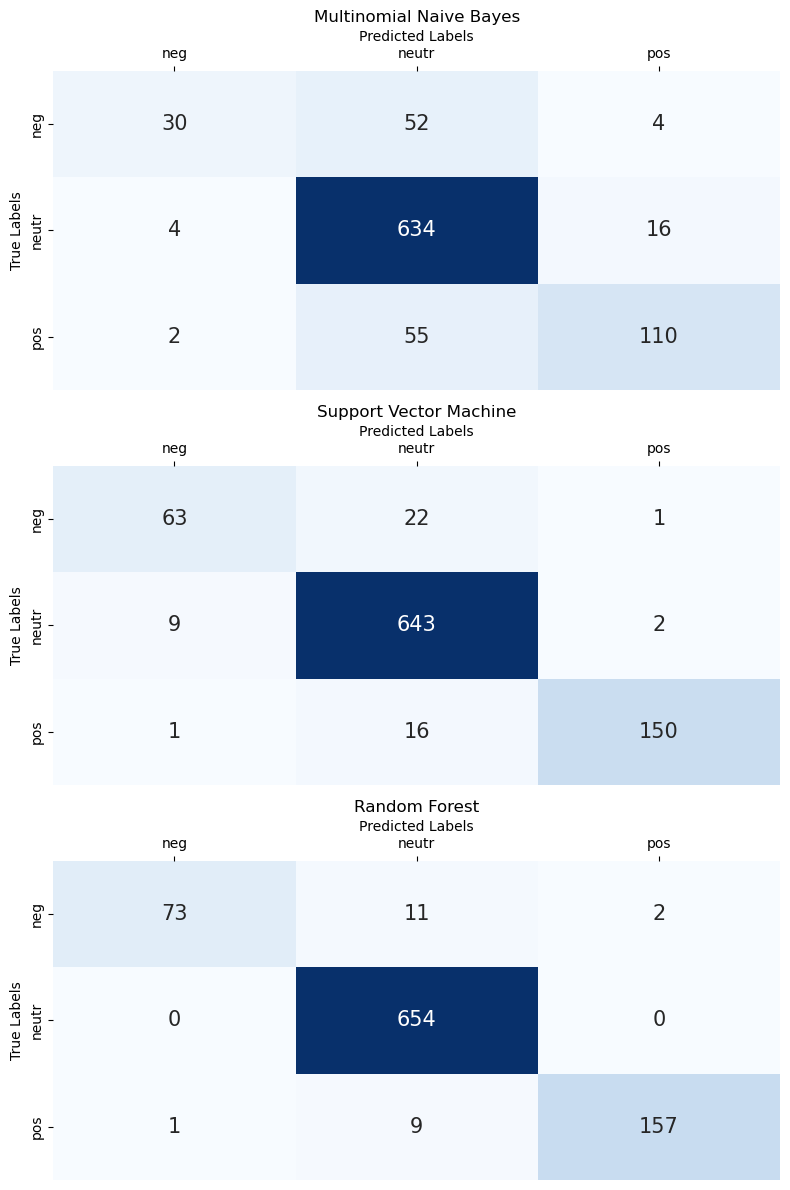

In [36]:
mnb_cm = confusion_matrix(y_test, mnb_y_test_pred)
svm_cm = confusion_matrix(y_test, svm_y_test_pred)
rf_cm = confusion_matrix(y_test, rf_y_test_pred)

labels = ['neg', 'neutr', 'pos']

fig, axes = plt.subplots(nrows=3, figsize=(8, 12))

sns.heatmap(mnb_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 15}, xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0])
axes[0].set_title("Naive Bayes")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')

sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 15}, xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[1])
axes[1].set_title("Support Vector Machine")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
axes[1].xaxis.tick_top()
axes[1].xaxis.set_label_position('top')

sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 15}, xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[2])
axes[2].set_title("Random Forest")
axes[2].set_xlabel("Predicted Labels")
axes[2].set_ylabel("True Labels")
axes[2].xaxis.tick_top()
axes[2].xaxis.set_label_position('top')

plt.tight_layout()
plt.show()
